In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from statsforecast import StatsForecast
from utilsforecast.plotting import plot_series

#ignore syntax warnings



In [11]:
df = pd.read_excel("actuals.xlsx")
df


,Country,Product,Date,Revenue
0,Australia,Cookies,2015-07-01,200
1,Australia,Cookies,2015-08-01,180
2,Australia,Cookies,2015-09-01,160
3,Australia,Cookies,2015-10-01,220
4,Australia,Cookies,2015-11-01,200
...,...,...,...,...
403,United States,Ice Cream,2023-08-01,1067
404,United States,Ice Cream,2023-09-01,1032
405,United States,Ice Cream,2023-10-01,1061
406,United States,Ice Cream,2023-11-01,1089


In [12]:
df['unique_id'] = df['Country'] + df['Product']

#drop first two columns
df = df.drop(['Country', 'Product'], axis=1)

df.columns = ['ds', 'y', 'unique_id']
#change column nam
df

,ds,y,unique_id
0,2015-07-01,200,AustraliaCookies
1,2015-08-01,180,AustraliaCookies
2,2015-09-01,160,AustraliaCookies
3,2015-10-01,220,AustraliaCookies
4,2015-11-01,200,AustraliaCookies
...,...,...,...
403,2023-08-01,1067,United StatesIce Cream
404,2023-09-01,1032,United StatesIce Cream
405,2023-10-01,1061,United StatesIce Cream
406,2023-11-01,1089,United StatesIce Cream


In [13]:
from pydantic import BaseModel, ValidationError
from datetime import datetime

# Define the Pydantic model to validate DataFrame schema
class DataFrameSchema(BaseModel):
    ds: datetime      # datetime #UPDATE TO TAKE IN INT AS WELl
    y: float          # float (also allows int because int is a subtype of float in this context)
    unique_id: object # any object type


def validate_dataframe(df):
    errors = []
    for _, row in df.iterrows():
        try:
            # Validate each row against the Pydantic model
            DataFrameSchema(**row.to_dict())
        except ValidationError as e:
            errors.append(e)
    return errors

# Function to convert 'Month, Year' to datetime
def convert_to_datetime(month_str):
    try:
        return pd.to_datetime(month_str, format='%B, %Y')
    except ValueError as e:
        print(f"Error converting {month_str}: {e}")
        return pd.NaT


#function to remove rows with na and 0 
def remove_na_and_0(df):
    df = df.dropna()
    df = df[df['y'] != 0]
    return df

    
# Run validation

df["ds"] = df["ds"].apply(convert_to_datetime)

df = remove_na_and_0(df)

# Function to determine global start and end
def determine_global_bounds(df, time_col):
    global_start = df[time_col].min()
    global_end = df[time_col].max()
    return global_start, global_end
# Calculate global start and end
global_start, global_end = determine_global_bounds(df, 'ds')
print(global_start, global_end)


def determine_local_bounds(df, time_col, unique_id_col):
    for unique_id in df[unique_id_col].unique():
        local_start = df[df[unique_id_col] == unique_id][time_col].min()
        local_end = df[df[unique_id_col] == unique_id][time_col].max()
        print(f"{unique_id}: {local_start} - {local_end}")

determine_local_bounds(df, 'ds', 'unique_id')
#fill gaps with from utilsforecast.preprocessing import fill_gaps

from utilsforecast.preprocessing import fill_gaps

df = fill_gaps(
    df,
    start=global_start,
    end=global_end,
    freq='M'
)


#seperate df by unique id, find local start and end, fill gaps
def fill_gaps_by_unique_id(df, time_col, unique_id_col):
    new_df = pd.DataFrame()
    for unique_id in df[unique_id_col].unique():
        local_df = df[df[unique_id_col] == unique_id]
        local_start = local_df[time_col].min()
        local_end = local_df[time_col].max()
        local_df = fill_gaps(
            local_df,
            start=local_start,
            end=local_end,
            freq='MS'
        )
        new_df = pd.concat([new_df, local_df])

    return df


df = fill_gaps_by_unique_id(df, 'ds', 'unique_id')
df = remove_na_and_0(df)

errors = validate_dataframe(df)
if errors:
    for error in errors:
        print(error)
else:
    print("Data validation passed.")

df

2015-07-01 00:00:00 2023-12-01 00:00:00
AustraliaCookies: 2015-07-01 00:00:00 - 2023-12-01 00:00:00
AustraliaIce Cream: 2015-07-01 00:00:00 - 2023-12-01 00:00:00
United StatesCookies: 2015-07-01 00:00:00 - 2023-12-01 00:00:00
United StatesIce Cream: 2015-07-01 00:00:00 - 2023-12-01 00:00:00
Data validation passed.


,unique_id,ds,y
0,AustraliaCookies,2015-07-01,200
1,AustraliaCookies,2015-08-01,180
2,AustraliaCookies,2015-09-01,160
3,AustraliaCookies,2015-10-01,220
4,AustraliaCookies,2015-11-01,200
...,...,...,...
403,United StatesIce Cream,2023-08-01,1067
404,United StatesIce Cream,2023-09-01,1032
405,United StatesIce Cream,2023-10-01,1061
406,United StatesIce Cream,2023-11-01,1089


In [37]:
# import polars as pl
# df = pl.from_pandas(df)
# df

In [14]:
season = 12
from statsforecast.models import (
    AutoARIMA,
    AutoETS,
    AutoTheta,
    AutoCES,
    AutoMFLES,
    HoltWinters,
    CrostonClassic as Croston, 
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
)


models = [
    AutoARIMA(season_length = season),
    AutoETS(season_length = season),
    AutoTheta(season_length = season),
    AutoCES(season_length = season),
    AutoMFLES(season_length = season, test_size=12*2),
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=season),
    DOT(season_length=season)
]

In [15]:
sf = StatsForecast( 
    models=models,
    freq="MS", 
    fallback_model = SeasonalNaive(season_length=season),
    n_jobs=-1,
)

In [16]:
forecasts_df = sf.forecast(df = df,h=6,level=[90])

In [17]:
forecasts_df

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90,AutoTheta,AutoTheta-lo-90,AutoTheta-hi-90,...,HoltWinters-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
unique_id,,,,,,,,,,,,,,,,,,,,,
AustraliaCookies,2024-01-01,652.062378,599.319397,704.805359,646.793274,558.927368,734.659119,677.758667,617.194031,754.150085,...,685.664734,596.0,506.335266,685.664734,596.0,506.335266,685.664734,667.920227,600.730164,752.668213
AustraliaCookies,2024-02-01,580.062378,527.127075,632.997681,606.527588,518.661682,694.393494,633.842529,567.269409,686.704895,...,613.664734,524.0,434.335266,613.664734,524.0,434.335266,613.664734,626.751953,554.499573,686.227234
AustraliaCookies,2024-03-01,725.062378,671.935425,778.189331,672.811218,584.945312,760.677124,700.407227,616.237549,766.882507,...,758.664734,669.0,579.335266,758.664734,669.0,579.335266,758.664734,694.896179,599.811035,768.198242
AustraliaCookies,2024-04-01,744.062378,690.744507,797.380249,738.971497,651.105530,826.837402,765.266846,684.236511,831.366577,...,777.664734,688.0,598.335266,777.664734,688.0,598.335266,777.664734,761.776062,675.940491,833.298889
AustraliaCookies,2024-05-01,663.062378,609.554260,716.570496,705.103760,617.237854,792.969727,728.561157,661.749695,809.080688,...,696.664734,607.0,517.335266,696.664734,607.0,517.335266,696.664734,727.638611,659.114990,812.315552
AustraliaCookies,2024-06-01,926.062378,872.364685,979.760071,816.378967,728.513000,904.244873,822.127869,740.785767,907.666687,...,959.664734,870.0,780.335266,959.664734,870.0,780.335266,959.664734,823.786011,740.007690,913.015320
AustraliaIce Cream,2024-01-01,2316.518066,2133.416504,2499.619629,2648.452881,2008.726685,3288.178955,3034.210938,2801.750732,3327.417480,...,1947.063965,1653.0,1358.936035,1947.063965,1653.0,1358.936035,1947.063965,3043.406738,2811.672119,3335.697754
AustraliaIce Cream,2024-02-01,1825.886475,1630.085815,2021.687134,2059.844727,1391.123047,2728.566162,2432.295166,2192.187744,2644.191650,...,1362.063965,1068.0,773.936035,1362.063965,1068.0,773.936035,1362.063965,2440.750244,2199.907959,2651.963135
AustraliaIce Cream,2024-03-01,1992.886475,1765.675415,2220.097656,2108.187256,1410.291992,2806.082764,2581.189697,2260.884766,2861.600342,...,1529.063965,1235.0,940.936035,1529.063965,1235.0,940.936035,1529.063965,2591.904541,2268.434570,2869.623535


ml forecast

In [18]:
#see type of type is df
type(df)

pandas.core.frame.DataFrame

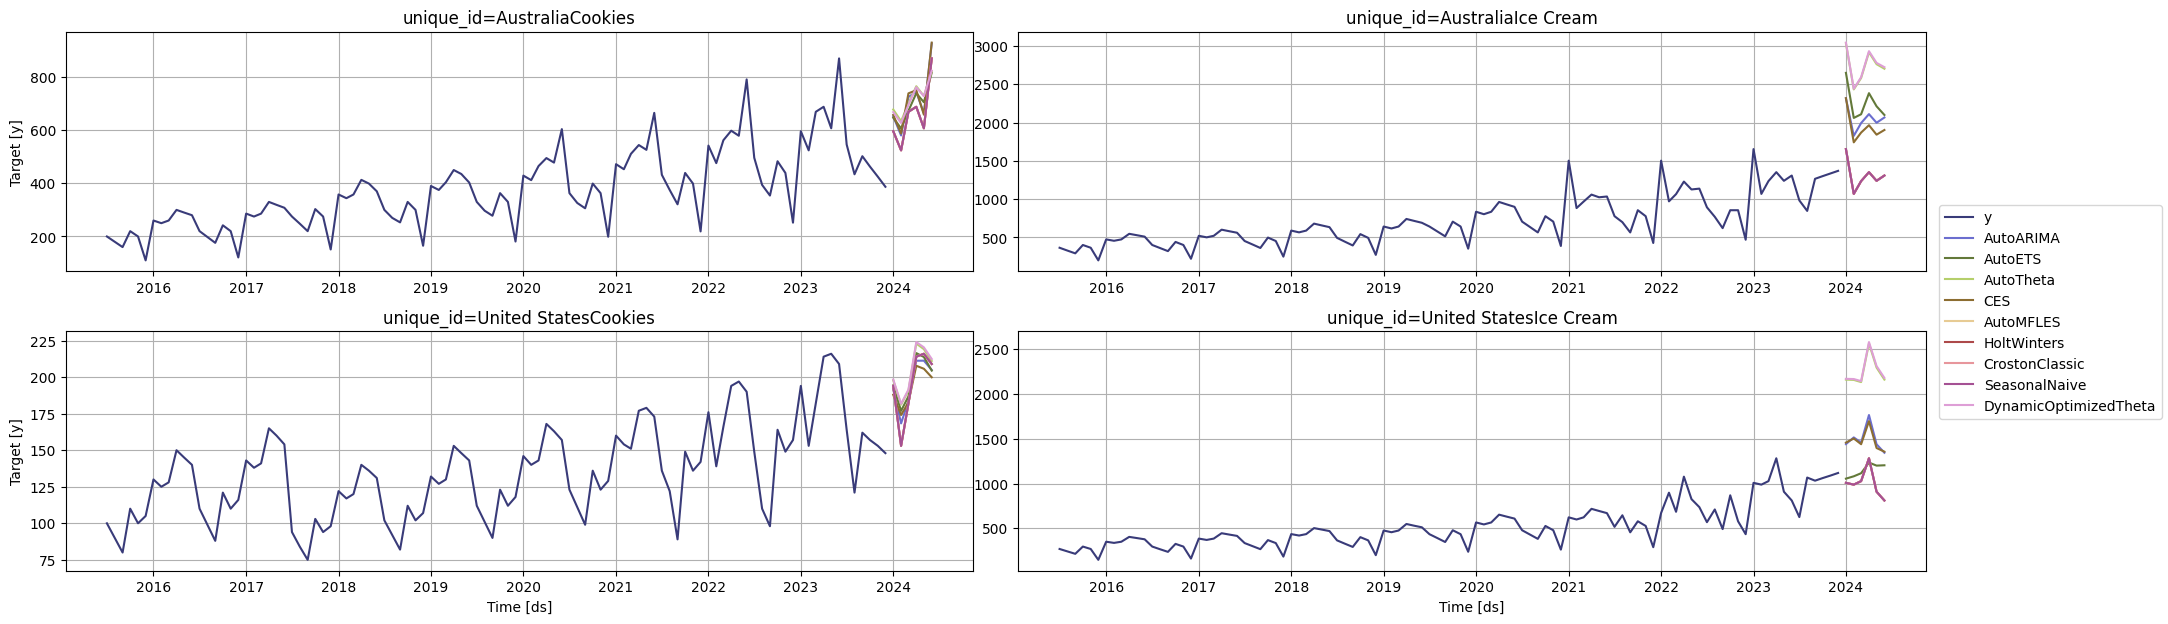

In [19]:
sf.plot(df, forecasts_df)

In [251]:
cross_val_df = sf.cross_validation(df = df, h=6, step_size = 6, n_windows = 3).reset_index(inplace=False)

In [252]:
cross_val_df 

,unique_id,ds,cutoff,y,AutoARIMA,AutoETS,AutoTheta,CES,AutoMFLES,HoltWinters,CrostonClassic,SeasonalNaive,DynamicOptimizedTheta
0,Surface Pro,2022-12-01,2022-11-01,167793216.0,232526288.0,309612672.0,288464192.0,248178560.0,251231664.0,269579680.0,210258736.0,269579680.0,287896512.0
1,Surface Pro,2023-01-01,2022-11-01,112992712.0,177244384.0,191464816.0,169659328.0,151786208.0,146961296.0,233211312.0,210258736.0,233211312.0,169051472.0
2,Surface Pro,2023-02-01,2022-11-01,161758608.0,171320592.0,192379776.0,173086400.0,154550464.0,147570944.0,230971904.0,210258736.0,230971904.0,172439248.0
3,Surface Pro,2023-03-01,2022-11-01,241624864.0,214868160.0,260993360.0,236967840.0,205385488.0,219430704.0,254729008.0,210258736.0,254729008.0,236282272.0
4,Surface Pro,2023-04-01,2022-11-01,124741536.0,139163968.0,162896208.0,142851968.0,128906888.0,120008608.0,141546400.0,210258736.0,141546400.0,142128800.0
5,Surface Pro,2023-05-01,2022-11-01,178384208.0,184427136.0,209943664.0,190812256.0,167543616.0,176039104.0,223908480.0,210258736.0,223908480.0,190052272.0
6,Surface Pro,2023-06-01,2023-05-01,212724448.0,180063824.0,211860400.0,221376624.0,203374912.0,207802880.0,247924496.0,189490560.0,247924496.0,220954368.0
7,Surface Pro,2023-07-01,2023-05-01,128861072.0,122071288.0,105842912.0,109436368.0,105296008.0,114440904.0,121586768.0,189490560.0,121586768.0,108988880.0
8,Surface Pro,2023-08-01,2023-05-01,161196144.0,142242256.0,177877056.0,187700144.0,179220128.0,157794880.0,156213200.0,189490560.0,156213200.0,187228368.0
9,Surface Pro,2023-09-01,2023-05-01,176615232.0,168099024.0,169647232.0,184767488.0,183248560.0,174776160.0,200343888.0,189490560.0,200343888.0,184272320.0


In [253]:
from utilsforecast.losses import smape
from utilsforecast.evaluation import evaluate
def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    # Calculate loss for every unique_id and cutoff.    
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals


In [254]:
evaluation_df = evaluate_cross_validation(cross_val_df, smape)
evaluation_df.head()


,AutoARIMA,AutoETS,AutoTheta,CES,AutoMFLES,HoltWinters,CrostonClassic,SeasonalNaive,DynamicOptimizedTheta,best_model
unique_id,,,,,,,,,,
Surface Pro,0.08599,0.12087,0.111781,0.092619,0.095561,0.122763,0.135362,0.122763,0.111161,AutoARIMA


In [10]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals
from mlforecast.lag_transforms import RollingMean, ExpandingStd



In [42]:
# lags = [1, 3, 12]
# lag_trans = {
#     1: [ExpandingStd()],
#     3: [RollingMean(window_size=3)],
#     12 : [RollingMean(window_size=12, min_samples=1), RollingMean(window_size=24)]
# }

# freq = "M"


# fcst = MLForecast(
#     models = [],
#     freq=freq,
#     lags=lags,
#     lag_transforms=lag_trans)

# prep = fcst.preprocess(df)
# prep


,unique_id,ds,y,lag1,lag3,lag12,expanding_std_lag1,rolling_mean_lag3_window_size3,rolling_mean_lag12_window_size12_min_samples1,rolling_mean_lag12_window_size24
21350,Windows 365 Enterprise,2024-05-01,3.076446e+07,5.240607e+07,2.762846e+07,1.265603e+07,1.432339e+07,2.461860e+07,1.190283e+07,7.120653e+06


In [28]:
from mlforecast.auto import (
    AutoLightGBM,
    AutoXGBoost,
    AutoLinearRegression,
    AutoRidge,
    AutoLasso,
    AutoElasticNet,
    AutoRandomForest
)

# Define all available models
models = [
    AutoLightGBM(),
    AutoXGBoost(),
    AutoLinearRegression(),
    AutoRidge(),
    AutoLasso(),
    AutoElasticNet(),
    AutoRandomForest()
]


In [30]:
from mlforecast.auto import AutoMLForecast

In [204]:
from utilsforecast.losses import mae, mse, rmse, mape, smape

def custom_mae(df, train_df=None):  # Accept train_df but do not use it
    return mae(df, models=["model"], id_col='unique_id', target_col='y')["model"].mean()

def custom_mse(df, train_df=None):  # Accept train_df but do not use it
    return mse(df, models=["model"], id_col='unique_id', target_col='y')["model"].mean()

def custom_rmse(df, train_df=None):  # Accept train_df but do not use it
    return rmse(df, models=["model"], id_col='unique_id', target_col='y')["model"].mean()

def custom_mape(df, train_df=None):  # Accept train_df but do not use it
    return mape(df, models=["model"], id_col='unique_id', target_col='y')["model"].mean()

def custom_smape(df, train_df=None):  # Accept train_df but do not use it
    return smape(df, models=["model"], id_col='unique_id', target_col='y')["model"].mean()



In [31]:
# Initialize an empty DataFrame to start the merging process
auto_preds = None
models_deployed = []
study_results =[]
# Iterate over each model
for model in models:
    try:
        auto_mlf = AutoMLForecast(
            models=[model],
            freq='MS',
            season_length=12
        )
        auto_mlf.fit(df=df, n_windows=3, h=6, num_samples=10)
        models_deployed.append(auto_mlf.models_)
        preds = auto_mlf.predict(6)

        
        study_results.append(auto_mlf.results_.items())
        try: 
            pred_ints = auto_mlf.forecast_fitted_values(level=[90])
        except Exception as e:
            print(f"Model {model.__class__.__name__} failed to generate prediction intervals due to error: {e}")
        # Ensure predictions have 'ds' and 'unique_id'
        preds.rename(columns={'y_pred': model.__class__.__name__}, inplace=True)  # Rename prediction column to model name
        
        if auto_preds is None:
            auto_preds = preds  # If first model, initialize auto_preds
        else:
            auto_preds = pd.merge(auto_preds, preds, on=['unique_id', 'ds'], how='outer')

        # if pred_ints is not None:
        #     # Merge prediction intervals
        #     auto_preds = pd.merge(auto_preds, pred_ints, on=['unique_id', 'ds'], how='outer')
        
        print(f"Model {model.__class__.__name__} succeeded. Predictions merged.")
    except Exception as e:
        print(f"Model {model.__class__.__name__} failed with error: {e}")

[I 2024-06-19 15:51:28,930] A new study created in memory with name: no-name-308043d5-34d5-491a-bbec-90b02ed4ebd6
[I 2024-06-19 15:51:29,569] Trial 0 finished with value: 0.07261362131633355 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 2, 'lag_transforms_idx': 2, 'use_date_features': 0}. Best is trial 0 with value: 0.07261362131633355.
[I 2024-06-19 15:51:29,942] Trial 1 finished with value: 0.1820144316056649 and parameters: {'n_estimators': 422, 'lambda_l1': 1.1600316346542318e-07, 'lambda_l2': 0.005744988873954126, 'num_leaves': 5, 'feature_fraction': 0.972334458524792, 'bagging_fraction': 0.7609241608750359, 'objective': 'l1', 'target_transforms_idx': 0, 'lags_idx': 0, 'lag_transforms_idx': 1, 'use_date_features': 1}. Best is trial 0 with value: 0.0726136213163335

Model AutoLightGBM failed to generate prediction intervals due to error: Please run the `fit` method using `fitted=True`
Model AutoLightGBM succeeded. Predictions merged.


[I 2024-06-19 15:51:32,915] Trial 0 finished with value: 0.06747301793174414 and parameters: {'n_estimators': 558, 'max_depth': 8, 'learning_rate': 0.024376795198947098, 'subsample': 0.5903948646972071, 'bagging_freq': 0.4812893194050143, 'colsample_bytree': 0.6813047017599905, 'min_data_in_leaf': 44.321133915006556, 'reg_lambda': 0.13620216352659412, 'reg_alpha': 0.5120378720005675, 'min_child_weight': 5, 'target_transforms_idx': 3, 'lags_idx': 2, 'lag_transforms_idx': 0, 'use_date_features': 0}. Best is trial 0 with value: 0.06747301793174414.
[I 2024-06-19 15:51:32,918] Trial 1 finished with value: inf and parameters: {'n_estimators': 647, 'max_depth': 2, 'learning_rate': 0.1491803130269481, 'subsample': 0.5696634895750645, 'bagging_freq': 0.4731957459914713, 'colsample_bytree': 0.3381000508941643, 'min_data_in_leaf': 77.64913525398745, 'reg_lambda': 4.458642564751387e-05, 'reg_alpha': 0.0003527537107422774, 'min_child_weight': 2, 'target_transforms_idx': 3, 'lags_idx': 0, 'lag_tran

Model AutoXGBoost failed to generate prediction intervals due to error: Please run the `fit` method using `fitted=True`
Model AutoXGBoost succeeded. Predictions merged.


[I 2024-06-19 15:51:36,884] Trial 1 finished with value: 0.05997255199586011 and parameters: {'fit_intercept': True, 'target_transforms_idx': 1, 'lags_idx': 1, 'lag_transforms_idx': 2, 'use_date_features': 1}. Best is trial 1 with value: 0.05997255199586011.
[I 2024-06-19 15:51:37,055] Trial 2 finished with value: 0.07140259881296128 and parameters: {'fit_intercept': False, 'target_transforms_idx': 2, 'lags_idx': 2, 'lag_transforms_idx': 3, 'use_date_features': 1}. Best is trial 1 with value: 0.05997255199586011.
[I 2024-06-19 15:51:37,157] Trial 3 finished with value: 0.061089129259399966 and parameters: {'fit_intercept': False, 'target_transforms_idx': 3, 'lags_idx': 2, 'lag_transforms_idx': 3, 'use_date_features': 0}. Best is trial 1 with value: 0.05997255199586011.
[I 2024-06-19 15:51:37,260] Trial 4 finished with value: 0.06738344577222831 and parameters: {'fit_intercept': True, 'target_transforms_idx': 2, 'lags_idx': 1, 'lag_transforms_idx': 3, 'use_date_features': 1}. Best is tr

Model AutoLinearRegression failed to generate prediction intervals due to error: Please run the `fit` method using `fitted=True`
Model AutoLinearRegression succeeded. Predictions merged.


[I 2024-06-19 15:51:37,751] Trial 1 finished with value: 0.06451410372206567 and parameters: {'fit_intercept': False, 'alpha': 9.786204803985408, 'target_transforms_idx': 6, 'lags_idx': 0, 'lag_transforms_idx': 0, 'use_date_features': 1}. Best is trial 1 with value: 0.06451410372206567.
[I 2024-06-19 15:51:37,998] Trial 2 finished with value: 0.06766392457068364 and parameters: {'fit_intercept': False, 'alpha': 9.437537037067727, 'target_transforms_idx': 3, 'lags_idx': 2, 'lag_transforms_idx': 3, 'use_date_features': 0}. Best is trial 1 with value: 0.06451410372206567.
[I 2024-06-19 15:51:38,098] Trial 3 finished with value: 0.06514194178491688 and parameters: {'fit_intercept': True, 'alpha': 6.531430146328519, 'target_transforms_idx': 5, 'lags_idx': 2, 'lag_transforms_idx': 3, 'use_date_features': 0}. Best is trial 1 with value: 0.06451410372206567.
[I 2024-06-19 15:51:38,204] Trial 4 finished with value: 0.06389820862284819 and parameters: {'fit_intercept': True, 'alpha': 7.392896530

Model AutoRidge failed to generate prediction intervals due to error: Please run the `fit` method using `fitted=True`
Model AutoRidge succeeded. Predictions merged.


[I 2024-06-19 15:51:38,940] Trial 2 finished with value: 0.23074517791584234 and parameters: {'fit_intercept': False, 'alpha': 9.437537037067727, 'target_transforms_idx': 3, 'lags_idx': 2, 'lag_transforms_idx': 3, 'use_date_features': 0}. Best is trial 1 with value: 0.06340272505449296.
[I 2024-06-19 15:51:39,071] Trial 3 finished with value: 0.06967963112227334 and parameters: {'fit_intercept': True, 'alpha': 6.531430146328519, 'target_transforms_idx': 5, 'lags_idx': 2, 'lag_transforms_idx': 3, 'use_date_features': 0}. Best is trial 1 with value: 0.06340272505449296.
[I 2024-06-19 15:51:39,192] Trial 4 finished with value: 0.06358780268862771 and parameters: {'fit_intercept': True, 'alpha': 7.392896530403619, 'target_transforms_idx': 6, 'lags_idx': 1, 'lag_transforms_idx': 3, 'use_date_features': 1}. Best is trial 1 with value: 0.06340272505449296.
[I 2024-06-19 15:51:39,249] Trial 5 pruned. 
[I 2024-06-19 15:51:39,357] Trial 6 finished with value: 0.0697502960334124 and parameters: {

Model AutoLasso failed to generate prediction intervals due to error: Please run the `fit` method using `fitted=True`
Model AutoLasso succeeded. Predictions merged.


[I 2024-06-19 15:51:39,843] Trial 1 finished with value: 0.2511888178245911 and parameters: {'fit_intercept': False, 'alpha': 7.99178648360302, 'l1_ratio': 0.46147936225293185, 'target_transforms_idx': 4, 'lags_idx': 1, 'lag_transforms_idx': 2, 'use_date_features': 1}. Best is trial 1 with value: 0.2511888178245911.
[I 2024-06-19 15:51:40,076] Trial 2 finished with value: 0.06134424970546661 and parameters: {'fit_intercept': True, 'alpha': 3.5957194978372864, 'l1_ratio': 0.43703195379934145, 'target_transforms_idx': 0, 'lags_idx': 1, 'lag_transforms_idx': 0, 'use_date_features': 1}. Best is trial 2 with value: 0.06134424970546661.
[I 2024-06-19 15:51:40,171] Trial 3 finished with value: 0.06936141112279148 and parameters: {'fit_intercept': False, 'alpha': 2.4450114944240258, 'l1_ratio': 0.15896958364551972, 'target_transforms_idx': 5, 'lags_idx': 2, 'lag_transforms_idx': 1, 'use_date_features': 0}. Best is trial 2 with value: 0.06134424970546661.
[I 2024-06-19 15:51:40,282] Trial 4 fin

Model AutoElasticNet failed to generate prediction intervals due to error: Please run the `fit` method using `fitted=True`
Model AutoElasticNet succeeded. Predictions merged.


[I 2024-06-19 15:51:42,388] Trial 0 finished with value: 0.15631608804989416 and parameters: {'n_estimators': 571, 'max_depth': 8, 'min_child_samples': 61, 'max_features': 0.7724415914984484, 'criterion': 'absolute_error', 'target_transforms_idx': 2, 'lags_idx': 0, 'lag_transforms_idx': 3, 'use_date_features': 1}. Best is trial 0 with value: 0.15631608804989416.
[I 2024-06-19 15:51:43,453] Trial 1 finished with value: 0.1691092564765239 and parameters: {'n_estimators': 809, 'max_depth': 5, 'min_child_samples': 79, 'max_features': 0.5591372129344666, 'criterion': 'squared_error', 'target_transforms_idx': 0, 'lags_idx': 1, 'lag_transforms_idx': 1, 'use_date_features': 0}. Best is trial 0 with value: 0.15631608804989416.
[I 2024-06-19 15:51:44,696] Trial 2 finished with value: 0.16207823539682442 and parameters: {'n_estimators': 713, 'max_depth': 1, 'min_child_samples': 67, 'max_features': 0.8353189348090797, 'criterion': 'squared_error', 'target_transforms_idx': 4, 'lags_idx': 1, 'lag_tr

Model AutoRandomForest failed to generate prediction intervals due to error: Please run the `fit` method using `fitted=True`
Model AutoRandomForest succeeded. Predictions merged.


In [306]:
import optuna
    # Assuming `auto_mlf.results_` is available
for auto_mlf in study_results:
    for model_name, study in auto_mlf:
        print(f"Best parameters for {model_name}: {study.best_params}\n---------------")  # Best parameters found
        print(f"Best loss value for {model_name}: {study.best_value}")  # Best objective value observed
        print('\n')
        
        # Print complete details of the best trial
        # print(f"Details of the best trial for {model_name}: {study.best_trial}")
    

   


Best parameters for AutoLightGBM: {'n_estimators': 281, 'lambda_l1': 2.6919795645288304e-06, 'lambda_l2': 0.04137578048520922, 'num_leaves': 3037, 'feature_fraction': 0.624376571759979, 'bagging_fraction': 0.7880786672089184, 'objective': 'l1', 'target_transforms_idx': 1, 'lags_idx': 2, 'lag_transforms_idx': 3, 'use_date_features': 1}
---------------
Best loss value for AutoLightGBM: 0.14199924758578494


Best parameters for AutoXGBoost: {'n_estimators': 152, 'max_depth': 3, 'learning_rate': 0.02048832034865783, 'subsample': 0.6317854851233559, 'bagging_freq': 0.6168927239646209, 'colsample_bytree': 0.6878807378714202, 'min_data_in_leaf': 65.5582237301672, 'reg_lambda': 2.8271410948251385e-05, 'reg_alpha': 0.1487211608929672, 'min_child_weight': 5, 'target_transforms_idx': 1, 'lags_idx': 1, 'lag_transforms_idx': 0, 'use_date_features': 1}
---------------
Best loss value for AutoXGBoost: 0.1748492704268454


Best parameters for AutoLinearRegression: {'fit_intercept': True, 'target_trans

In [307]:
print("Optimized Models Deployed:\n--------------------------")
models_deployed

Optimized Models Deployed:
--------------------------


[{'AutoLightGBM': MLForecast(models=[AutoLightGBM], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'exponentially_weighted_mean_lag1_alpha0.9', 'rolling_mean_lag12_window_size12_min_samples1', 'rolling_mean_lag6_window_size12_min_samples1'], date_features=['month', 'year'], num_threads=1)},
 {'AutoXGBoost': MLForecast(models=[AutoXGBoost], freq=MS, lag_features=['lag12'], date_features=['month', 'year'], num_threads=1)},
 {'AutoLinearRegression': MLForecast(models=[AutoLinearRegression], freq=MS, lag_features=['lag12', 'exponentially_weighted_mean_lag1_alpha0.9'], date_features=[], num_threads=1)},
 {'AutoRidge': MLForecast(models=[AutoRidge], freq=MS, lag_features=['lag12', 'exponentially_weighted_mean_lag1_alpha0.9', 'rolling_mean_lag12_window_size12_min_samples1'], date_features=[], num_threads=1)},
 {'AutoLasso': MLForecast(models=[AutoLasso], freq=MS, lag_features=['exponentially_weighted_mean_lag1_alpha0.9

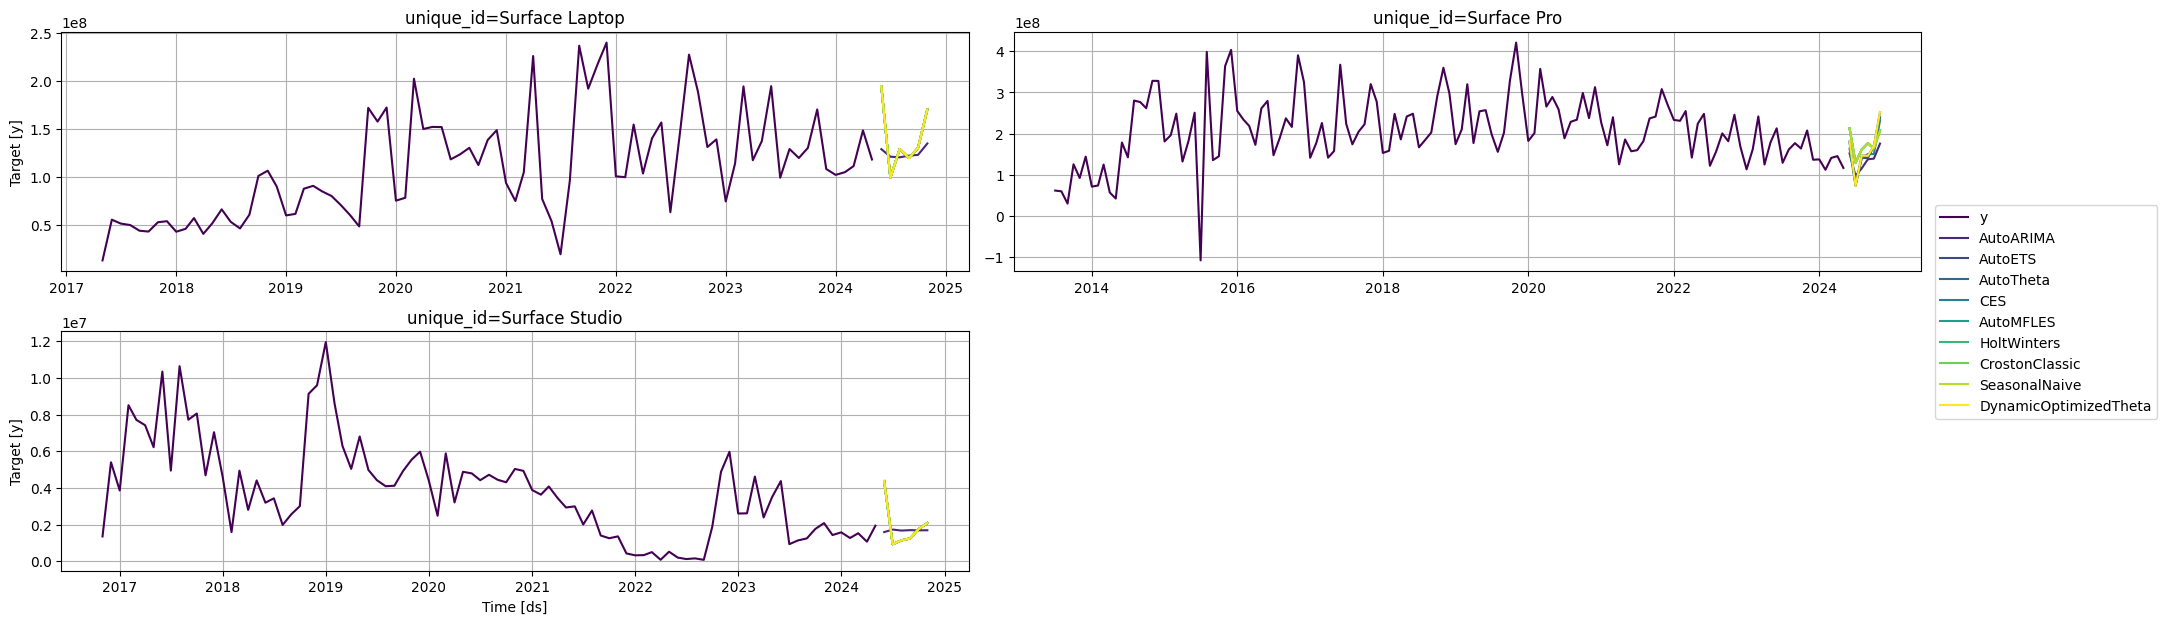

In [308]:
plot_series(df, forecasts_df.reset_index(inplace=False))

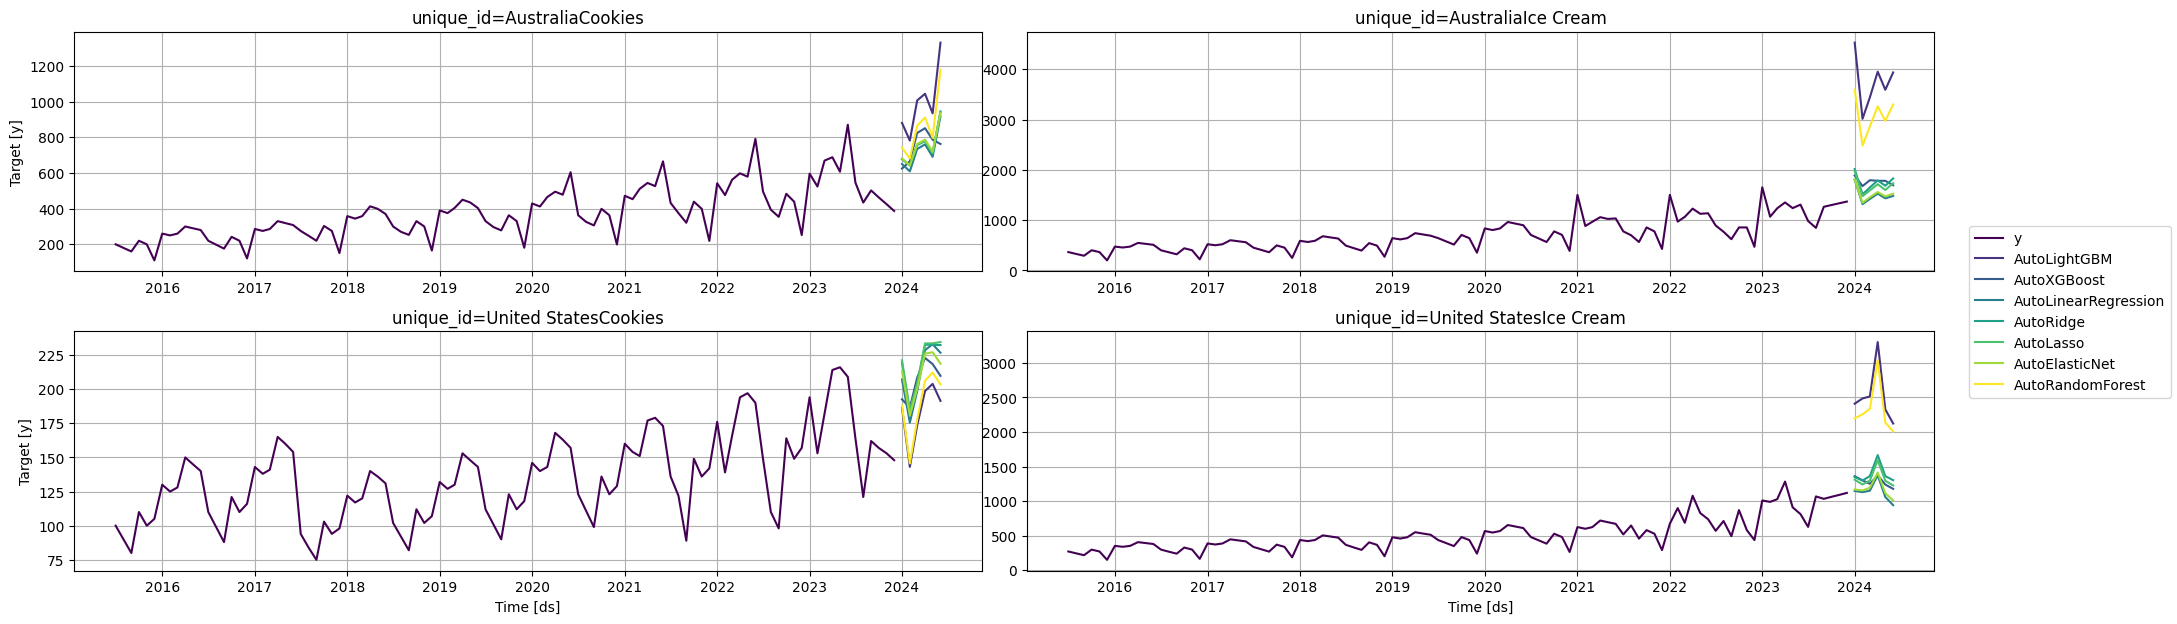

In [32]:
plot_series(df, auto_preds)

In [310]:
auto_preds

,unique_id,ds,AutoLightGBM,AutoXGBoost,AutoLinearRegression,AutoRidge,AutoLasso,AutoElasticNet,AutoRandomForest
0,Surface Laptop,2024-06-01,1.169821e+08,1.117620e+08,1.387535e+08,1.411124e+08,1.190916e+08,1.280534e+08,1.325245e+08
1,Surface Laptop,2024-07-01,1.069853e+08,7.766440e+07,1.189433e+08,1.117772e+08,1.198567e+08,1.176712e+08,1.248447e+08
2,Surface Laptop,2024-08-01,1.056704e+08,9.471371e+07,1.207135e+08,1.284097e+08,1.206217e+08,1.229148e+08,1.364212e+08
3,Surface Laptop,2024-09-01,1.437818e+08,9.154686e+07,1.181412e+08,1.229380e+08,1.213867e+08,1.243121e+08,1.421953e+08
4,Surface Laptop,2024-10-01,1.412443e+08,1.035841e+08,1.201085e+08,1.277366e+08,1.221518e+08,1.270941e+08,1.524773e+08
5,Surface Laptop,2024-11-01,1.397119e+08,1.404792e+08,1.316954e+08,1.365991e+08,1.229168e+08,1.324163e+08,1.656048e+08
6,Surface Pro,2024-06-01,1.184807e+08,1.784994e+08,1.757938e+08,1.327192e+08,1.158818e+08,1.254911e+08,1.379284e+08
7,Surface Pro,2024-07-01,1.093260e+08,1.402258e+08,1.729220e+08,1.066760e+08,1.153897e+08,1.149548e+08,1.209366e+08
8,Surface Pro,2024-08-01,1.033207e+08,1.552172e+08,1.828002e+08,1.212798e+08,1.148976e+08,1.200263e+08,1.385398e+08
9,Surface Pro,2024-09-01,1.065080e+08,1.645823e+08,1.906548e+08,1.202891e+08,1.144055e+08,1.242233e+08,1.470428e+08


In [20]:
# MLForecast framework
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.lag_transforms import RollingMean, ExpandingStd
from mlforecast.utils import PredictionIntervals

# Scikit-learn models
from sklearn.linear_model import (
    LinearRegression, 
    TheilSenRegressor,
    RANSACRegressor,
    HuberRegressor,
    QuantileRegressor,
    Lasso, 
    LassoCV,
    Ridge, 
    ElasticNet, 
    ElasticNetCV,

)
from sklearn.neighbors import (
    KNeighborsRegressor,
    )

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    HistGradientBoostingRegressor,
    AdaBoostRegressor,
    BaggingRegressor)
from sklearn.svm import SVR, LinearSVR

# XGBoost and LightGBM
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [21]:
# Initialize all models
models = {
    'lasso': Lasso(),
    'lasso_cv': LassoCV(),
    'ridge': Ridge(),
    'linear': LinearRegression(),
    'theil_sen': TheilSenRegressor(),
    'ransac': RANSACRegressor(random_state=0),
    'huber': HuberRegressor(),
    'quantile': QuantileRegressor(),
    'knn': KNeighborsRegressor(),
    'mlp': MLPRegressor(random_state=0),
    'rf': RandomForestRegressor(random_state=0),
    'gbm': GradientBoostingRegressor(random_state=0),
    'extra_trees': ExtraTreesRegressor(random_state=0),
    'hist_gbm': HistGradientBoostingRegressor(random_state=0),
    'adaboost': AdaBoostRegressor(random_state=0),
    'bagging': BaggingRegressor(random_state=0),
    'svr': SVR(),
    'linear_svr': LinearSVR(),
    'elastic': ElasticNet(),
    'elastic_cv': ElasticNetCV(),
    'xgb': XGBRegressor(random_state=0),
    'lgb': LGBMRegressor(random_state=0)
}


# Instantiate MLForecast with your models and transformations
fcst = MLForecast(
    models=models,
    freq='MS',  # 'M' for monthly frequency
    lags=[1, 3, 12], 
    date_features=['month'], # using lags of 1 month and 12 months
    lag_transforms={
        1: [RollingMean(window_size=3), ExpandingStd()],
        3: [RollingMean(window_size=3)],
        12: [RollingMean(window_size=12)]
    },
    
    target_transforms=[Differences([1])]
)

In [22]:
df

,unique_id,ds,y
0,AustraliaCookies,2015-07-01,200
1,AustraliaCookies,2015-08-01,180
2,AustraliaCookies,2015-09-01,160
3,AustraliaCookies,2015-10-01,220
4,AustraliaCookies,2015-11-01,200
...,...,...,...
403,United StatesIce Cream,2023-08-01,1067
404,United StatesIce Cream,2023-09-01,1032
405,United StatesIce Cream,2023-10-01,1061
406,United StatesIce Cream,2023-11-01,1089


In [49]:
fcst.fit(df=df, 
        id_col='unique_id',
        time_col='ds',
        target_col='y',
        prediction_intervals=PredictionIntervals())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 304, number of used features: 8
[LightGBM] [Info] Start training from score 5.072368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

MLForecast(models=[lasso, lasso_cv, ridge, linear, theil_sen, ransac, huber, quantile, knn, mlp, rf, gbm, extra_trees, hist_gbm, adaboost, bagging, svr, linear_svr, elastic, elastic_cv, xgb, lgb], freq=MS, lag_features=['lag1', 'lag3', 'lag12', 'rolling_mean_lag1_window_size3', 'expanding_std_lag1', 'rolling_mean_lag3_window_size3', 'rolling_mean_lag12_window_size12'], date_features=['month'], num_threads=1)

In [50]:
prep = fcst.preprocess(df)
prep.head()


,unique_id,ds,y,lag1,lag3,lag12,rolling_mean_lag1_window_size3,expanding_std_lag1,rolling_mean_lag3_window_size3,rolling_mean_lag12_window_size12,month
24,AustraliaCookies,2017-07-01,-33.0,-11.0,44.0,-60.0,7.333333,62.430645,14.666667,1.666667,7
25,AustraliaCookies,2017-08-01,-27.0,-33.0,-11.0,-22.0,-18.333334,61.541302,14.666667,1.500000,8
26,AustraliaCookies,2017-09-01,-28.0,-27.0,-11.0,-22.0,-23.666666,60.546074,7.333333,1.333333,9
27,AustraliaCookies,2017-10-01,83.0,-28.0,-33.0,66.0,-29.333334,59.612289,-18.333334,1.833333,10
28,AustraliaCookies,2017-11-01,-28.0,83.0,-27.0,-22.0,9.333333,60.558964,-23.666666,1.666667,11


In [53]:
models_deployed

[{'AutoLightGBM': MLForecast(models=[AutoLightGBM], freq=MS, lag_features=['exponentially_weighted_mean_lag1_alpha0.9', 'rolling_mean_lag12_window_size12_min_samples1'], date_features=['month', 'year'], num_threads=1)},
 {'AutoXGBoost': MLForecast(models=[AutoXGBoost], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12'], date_features=[], num_threads=1)},
 {'AutoLinearRegression': MLForecast(models=[AutoLinearRegression], freq=MS, lag_features=['lag12', 'exponentially_weighted_mean_lag1_alpha0.9', 'rolling_mean_lag12_window_size12_min_samples1'], date_features=['month', 'year'], num_threads=1)},
 {'AutoRidge': MLForecast(models=[AutoRidge], freq=MS, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'exponentially_weighted_mean_lag1_alpha0.9', 'rolling_mean_lag12_window_size12_min_samples1'], date_features=[], num_threads=1)},
 {'AutoLasso': MLForecast(mod

In [51]:
X = prep.drop(columns=['unique_id', 'ds', 'y'])
X.head()


,lag1,lag3,lag12,rolling_mean_lag1_window_size3,expanding_std_lag1,rolling_mean_lag3_window_size3,rolling_mean_lag12_window_size12,month
24,-11.0,44.0,-60.0,7.333333,62.430645,14.666667,1.666667,7
25,-33.0,-11.0,-22.0,-18.333334,61.541302,14.666667,1.500000,8
26,-27.0,-11.0,-22.0,-23.666666,60.546074,7.333333,1.333333,9
27,-28.0,-33.0,66.0,-29.333334,59.612289,-18.333334,1.833333,10
28,83.0,-27.0,-22.0,9.333333,60.558964,-23.666666,1.666667,11


In [47]:
import shap

In [52]:
X100 = shap.utils.sample(X, 30)
explainer = shap.Explainer(fcst.models_['quantile'].predict, X100)
shap_values = explainer(X)


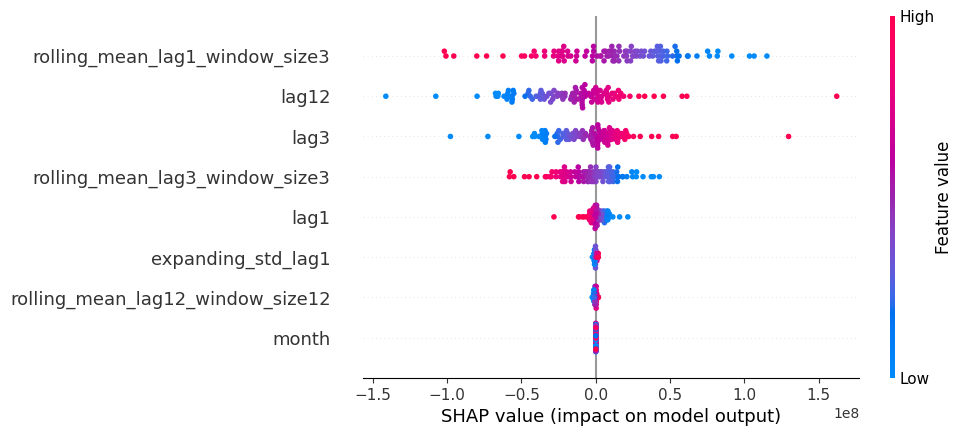

In [266]:
shap.plots.beeswarm(shap_values)


In [53]:
auto_preds

,unique_id,ds,AutoLightGBM,AutoXGBoost,AutoLinearRegression,AutoRidge,AutoLasso,AutoElasticNet,AutoRandomForest
0,Surface Pro,2024-06-01,1.504019e+08,1.256220e+08,1.710128e+08,1.367627e+08,1.755334e+08,1.716398e+08,1.452777e+08
1,Surface Pro,2024-07-01,1.194448e+08,6.639793e+07,7.736119e+07,1.019863e+08,1.472466e+08,1.452463e+08,9.599463e+07
2,Surface Pro,2024-08-01,1.415743e+08,7.402007e+07,1.070000e+08,1.382523e+08,1.638366e+08,1.551270e+08,1.250011e+08
3,Surface Pro,2024-09-01,1.489860e+08,1.002466e+08,1.434928e+08,1.454506e+08,1.738935e+08,1.661467e+08,1.479758e+08
4,Surface Pro,2024-10-01,1.874805e+08,1.046919e+08,1.246338e+08,1.600227e+08,1.729891e+08,1.633118e+08,1.490583e+08
5,Surface Pro,2024-11-01,1.946973e+08,1.226385e+08,1.577858e+08,1.992588e+08,1.940265e+08,1.862377e+08,1.776074e+08


In [37]:
forecasts_df.reset_index(inplace=True)
forecasts_df

,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90,AutoTheta,AutoTheta-lo-90,...,HoltWinters-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
0,AustraliaCookies,2024-01-01,652.062378,599.319397,704.805359,646.793274,558.927368,734.659119,677.758667,617.194031,...,685.664734,596.0,506.335266,685.664734,596.0,506.335266,685.664734,667.920227,600.730164,752.668213
1,AustraliaCookies,2024-02-01,580.062378,527.127075,632.997681,606.527588,518.661682,694.393494,633.842529,567.269409,...,613.664734,524.0,434.335266,613.664734,524.0,434.335266,613.664734,626.751953,554.499573,686.227234
2,AustraliaCookies,2024-03-01,725.062378,671.935425,778.189331,672.811218,584.945312,760.677124,700.407227,616.237549,...,758.664734,669.0,579.335266,758.664734,669.0,579.335266,758.664734,694.896179,599.811035,768.198242
3,AustraliaCookies,2024-04-01,744.062378,690.744507,797.380249,738.971497,651.105530,826.837402,765.266846,684.236511,...,777.664734,688.0,598.335266,777.664734,688.0,598.335266,777.664734,761.776062,675.940491,833.298889
4,AustraliaCookies,2024-05-01,663.062378,609.554260,716.570496,705.103760,617.237854,792.969727,728.561157,661.749695,...,696.664734,607.0,517.335266,696.664734,607.0,517.335266,696.664734,727.638611,659.114990,812.315552
5,AustraliaCookies,2024-06-01,926.062378,872.364685,979.760071,816.378967,728.513000,904.244873,822.127869,740.785767,...,959.664734,870.0,780.335266,959.664734,870.0,780.335266,959.664734,823.786011,740.007690,913.015320
6,AustraliaIce Cream,2024-01-01,2316.518066,2133.416504,2499.619629,2648.452881,2008.726685,3288.178955,3034.210938,2801.750732,...,1947.063965,1653.0,1358.936035,1947.063965,1653.0,1358.936035,1947.063965,3043.406738,2811.672119,3335.697754
7,AustraliaIce Cream,2024-02-01,1825.886475,1630.085815,2021.687134,2059.844727,1391.123047,2728.566162,2432.295166,2192.187744,...,1362.063965,1068.0,773.936035,1362.063965,1068.0,773.936035,1362.063965,2440.750244,2199.907959,2651.963135
8,AustraliaIce Cream,2024-03-01,1992.886475,1765.675415,2220.097656,2108.187256,1410.291992,2806.082764,2581.189697,2260.884766,...,1529.063965,1235.0,940.936035,1529.063965,1235.0,940.936035,1529.063965,2591.904541,2268.434570,2869.623535
9,AustraliaIce Cream,2024-04-01,2109.886475,1855.108398,2364.664795,2383.269043,1649.664429,3116.873535,2916.865723,2593.671143,...,1646.063965,1352.0,1057.936035,1646.063965,1352.0,1057.936035,1646.063965,2931.566162,2601.128662,3239.701660


In [34]:
preds = fcst.predict(h=6, level=[90])

In [35]:
preds

,unique_id,ds,lasso,lasso_cv,ridge,linear,theil_sen,ransac,huber,quantile,...,linear_svr-lo-90,linear_svr-hi-90,elastic-lo-90,elastic-hi-90,elastic_cv-lo-90,elastic_cv-hi-90,xgb-lo-90,xgb-hi-90,lgb-lo-90,lgb-hi-90
0,AustraliaCookies,2024-01-01,752.652954,733.692200,753.434570,753.444946,753.963562,766.452393,764.595764,764.901733,...,665.602674,919.491564,641.246960,861.840930,618.020435,831.578931,422.188677,699.029218,551.339017,819.821383
1,AustraliaCookies,2024-02-01,631.931458,605.723389,632.994141,633.009399,649.959778,691.465454,683.872498,685.051392,...,581.814588,835.703478,519.933728,740.527698,486.322742,699.881238,305.945513,582.786054,322.328489,590.810854
2,AustraliaCookies,2024-03-01,776.134338,750.714111,777.144409,777.160400,795.379700,842.392212,842.446289,844.464233,...,771.282545,1025.171435,664.023816,884.617786,631.369312,844.927808,533.694415,810.534956,615.258573,883.740939
3,AustraliaCookies,2024-04-01,785.331604,763.101501,786.190979,786.204590,806.003540,857.427917,860.415161,864.918335,...,770.754346,1024.643237,673.475537,894.069507,644.784534,858.343030,414.700762,691.541303,539.284330,807.766695
4,AustraliaCookies,2024-05-01,703.104736,676.997925,704.108582,704.123779,710.352539,759.485352,772.507935,775.814270,...,691.506605,945.395495,591.065808,811.659778,556.253833,769.812329,311.562609,588.403150,389.441068,657.923434
5,AustraliaCookies,2024-06-01,951.919983,938.596436,952.381409,952.386230,982.873413,1023.896484,1058.659424,1064.719971,...,990.707288,1244.596178,841.102979,1061.696948,822.768115,1036.326611,586.889971,863.730512,786.750150,1055.232516
6,AustraliaIce Cream,2024-01-01,2453.591797,2460.637695,2453.310791,2453.295410,2586.510986,2635.859375,2662.001465,2668.209473,...,2406.327277,3100.116083,2096.520563,2814.770453,2107.742581,2815.491794,1942.744336,2411.456836,1415.677386,1877.837994
7,AustraliaIce Cream,2024-02-01,1680.396240,1690.657227,1679.986084,1679.970825,1861.070557,1987.429932,2013.704956,2022.982422,...,1719.132452,2412.921259,1323.154840,2041.404730,1338.710233,2046.459445,1407.337476,1876.049976,945.772968,1407.933575
8,AustraliaIce Cream,2024-03-01,1957.721069,1965.704102,1957.410645,1957.398193,2051.991699,2154.062744,2203.935547,2207.607178,...,1982.857062,2676.645868,1600.208795,2318.458685,1612.876126,2320.625339,1585.170117,2053.882617,1266.152240,1728.312848
9,AustraliaIce Cream,2024-04-01,2112.722656,2128.459717,2112.104492,2112.081543,2185.475586,2272.457520,2329.066650,2335.403809,...,2032.091193,2725.879999,1756.503961,2474.753851,1778.695462,2486.444675,1713.849805,2182.562305,1446.407123,1908.567731


In [60]:
# #reset indexes for all dataframes
# forecasts_df.reset_index(inplace=True)
# auto_preds.reset_index(inplace=True)
# preds.reset_index(inplace=True)

In [61]:
preds

,unique_id,ds,lasso,lasso_cv,ridge,linear,theil_sen,ransac,huber,quantile,...,linear_svr-lo-90,linear_svr-hi-90,elastic-lo-90,elastic-hi-90,elastic_cv-lo-90,elastic_cv-hi-90,xgb-lo-90,xgb-hi-90,lgb-lo-90,lgb-hi-90
0,Surface Pro,2024-06-01,1.177269e+08,1.252810e+08,1.177331e+08,1.177269e+08,1.218696e+08,1.137257e+08,1.359864e+08,1.350939e+08,...,4.665660e+07,2.794218e+08,3.933243e+07,1.967477e+08,5.709829e+07,1.945318e+08,-1.094552e+08,2.494062e+08,4.378841e+06,1.909371e+08
1,Surface Pro,2024-07-01,8.861391e+07,7.981392e+07,8.860242e+07,8.861391e+07,8.134519e+07,3.939388e+07,9.079792e+07,9.094043e+07,...,-4.640413e+07,1.863611e+08,9.323705e+06,1.667389e+08,1.182832e+07,1.492618e+08,-2.402411e+08,1.186203e+08,-6.938998e+07,1.171683e+08
2,Surface Pro,2024-08-01,1.262179e+08,1.086154e+08,1.261999e+08,1.262179e+08,1.146710e+08,6.899160e+07,1.284820e+08,1.257989e+08,...,3.227828e+07,2.650435e+08,4.659333e+07,2.040086e+08,4.073739e+07,1.781709e+08,-2.523344e+08,1.065270e+08,3.071675e+07,2.172751e+08
3,Surface Pro,2024-09-01,1.224662e+08,9.727026e+07,1.224408e+08,1.224662e+08,1.149973e+08,6.407154e+07,1.265189e+08,1.242603e+08,...,1.191188e+07,2.446771e+08,4.246415e+07,1.998794e+08,2.963427e+07,1.670678e+08,-3.260707e+08,3.279067e+07,-1.913946e+07,1.674188e+08
4,Surface Pro,2024-10-01,1.329793e+08,8.911633e+07,1.329370e+08,1.329793e+08,1.138408e+08,5.660344e+07,1.220923e+08,1.197027e+08,...,1.719547e+07,2.499607e+08,5.210636e+07,2.095216e+08,2.173824e+07,1.591717e+08,-2.743195e+08,8.454189e+07,3.025130e+07,2.168096e+08
5,Surface Pro,2024-11-01,1.523718e+08,9.470710e+07,1.523168e+08,1.523718e+08,1.308164e+08,7.728039e+07,1.353078e+08,1.327255e+08,...,5.097837e+07,2.837436e+08,7.084931e+07,2.282645e+08,2.769016e+07,1.651236e+08,-3.795363e+08,-2.067486e+07,-8.428249e+06,1.781301e+08


In [38]:
for_merge_auto = auto_preds.copy().drop(columns=['ds', 'unique_id'])
for_merge_fcst = forecasts_df.copy().drop(columns=['ds', 'unique_id'])


In [39]:
preds_all = preds.merge(for_merge_auto, left_index=True, right_index=True, how='outer')
preds_all = preds_all.merge(for_merge_fcst, left_index=True, right_index=True, how='outer')

preds_all

,unique_id,ds,lasso,lasso_cv,ridge,linear,theil_sen,ransac,huber,quantile,...,HoltWinters-hi-90,CrostonClassic,CrostonClassic-lo-90,CrostonClassic-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,DynamicOptimizedTheta,DynamicOptimizedTheta-lo-90,DynamicOptimizedTheta-hi-90
0,AustraliaCookies,2024-01-01,752.652954,733.692200,753.434570,753.444946,753.963562,766.452393,764.595764,764.901733,...,685.664734,596.0,506.335266,685.664734,596.0,506.335266,685.664734,667.920227,600.730164,752.668213
1,AustraliaCookies,2024-02-01,631.931458,605.723389,632.994141,633.009399,649.959778,691.465454,683.872498,685.051392,...,613.664734,524.0,434.335266,613.664734,524.0,434.335266,613.664734,626.751953,554.499573,686.227234
2,AustraliaCookies,2024-03-01,776.134338,750.714111,777.144409,777.160400,795.379700,842.392212,842.446289,844.464233,...,758.664734,669.0,579.335266,758.664734,669.0,579.335266,758.664734,694.896179,599.811035,768.198242
3,AustraliaCookies,2024-04-01,785.331604,763.101501,786.190979,786.204590,806.003540,857.427917,860.415161,864.918335,...,777.664734,688.0,598.335266,777.664734,688.0,598.335266,777.664734,761.776062,675.940491,833.298889
4,AustraliaCookies,2024-05-01,703.104736,676.997925,704.108582,704.123779,710.352539,759.485352,772.507935,775.814270,...,696.664734,607.0,517.335266,696.664734,607.0,517.335266,696.664734,727.638611,659.114990,812.315552
5,AustraliaCookies,2024-06-01,951.919983,938.596436,952.381409,952.386230,982.873413,1023.896484,1058.659424,1064.719971,...,959.664734,870.0,780.335266,959.664734,870.0,780.335266,959.664734,823.786011,740.007690,913.015320
6,AustraliaIce Cream,2024-01-01,2453.591797,2460.637695,2453.310791,2453.295410,2586.510986,2635.859375,2662.001465,2668.209473,...,1947.063965,1653.0,1358.936035,1947.063965,1653.0,1358.936035,1947.063965,3043.406738,2811.672119,3335.697754
7,AustraliaIce Cream,2024-02-01,1680.396240,1690.657227,1679.986084,1679.970825,1861.070557,1987.429932,2013.704956,2022.982422,...,1362.063965,1068.0,773.936035,1362.063965,1068.0,773.936035,1362.063965,2440.750244,2199.907959,2651.963135
8,AustraliaIce Cream,2024-03-01,1957.721069,1965.704102,1957.410645,1957.398193,2051.991699,2154.062744,2203.935547,2207.607178,...,1529.063965,1235.0,940.936035,1529.063965,1235.0,940.936035,1529.063965,2591.904541,2268.434570,2869.623535
9,AustraliaIce Cream,2024-04-01,2112.722656,2128.459717,2112.104492,2112.081543,2185.475586,2272.457520,2329.066650,2335.403809,...,1646.063965,1352.0,1057.936035,1646.063965,1352.0,1057.936035,1646.063965,2931.566162,2601.128662,3239.701660


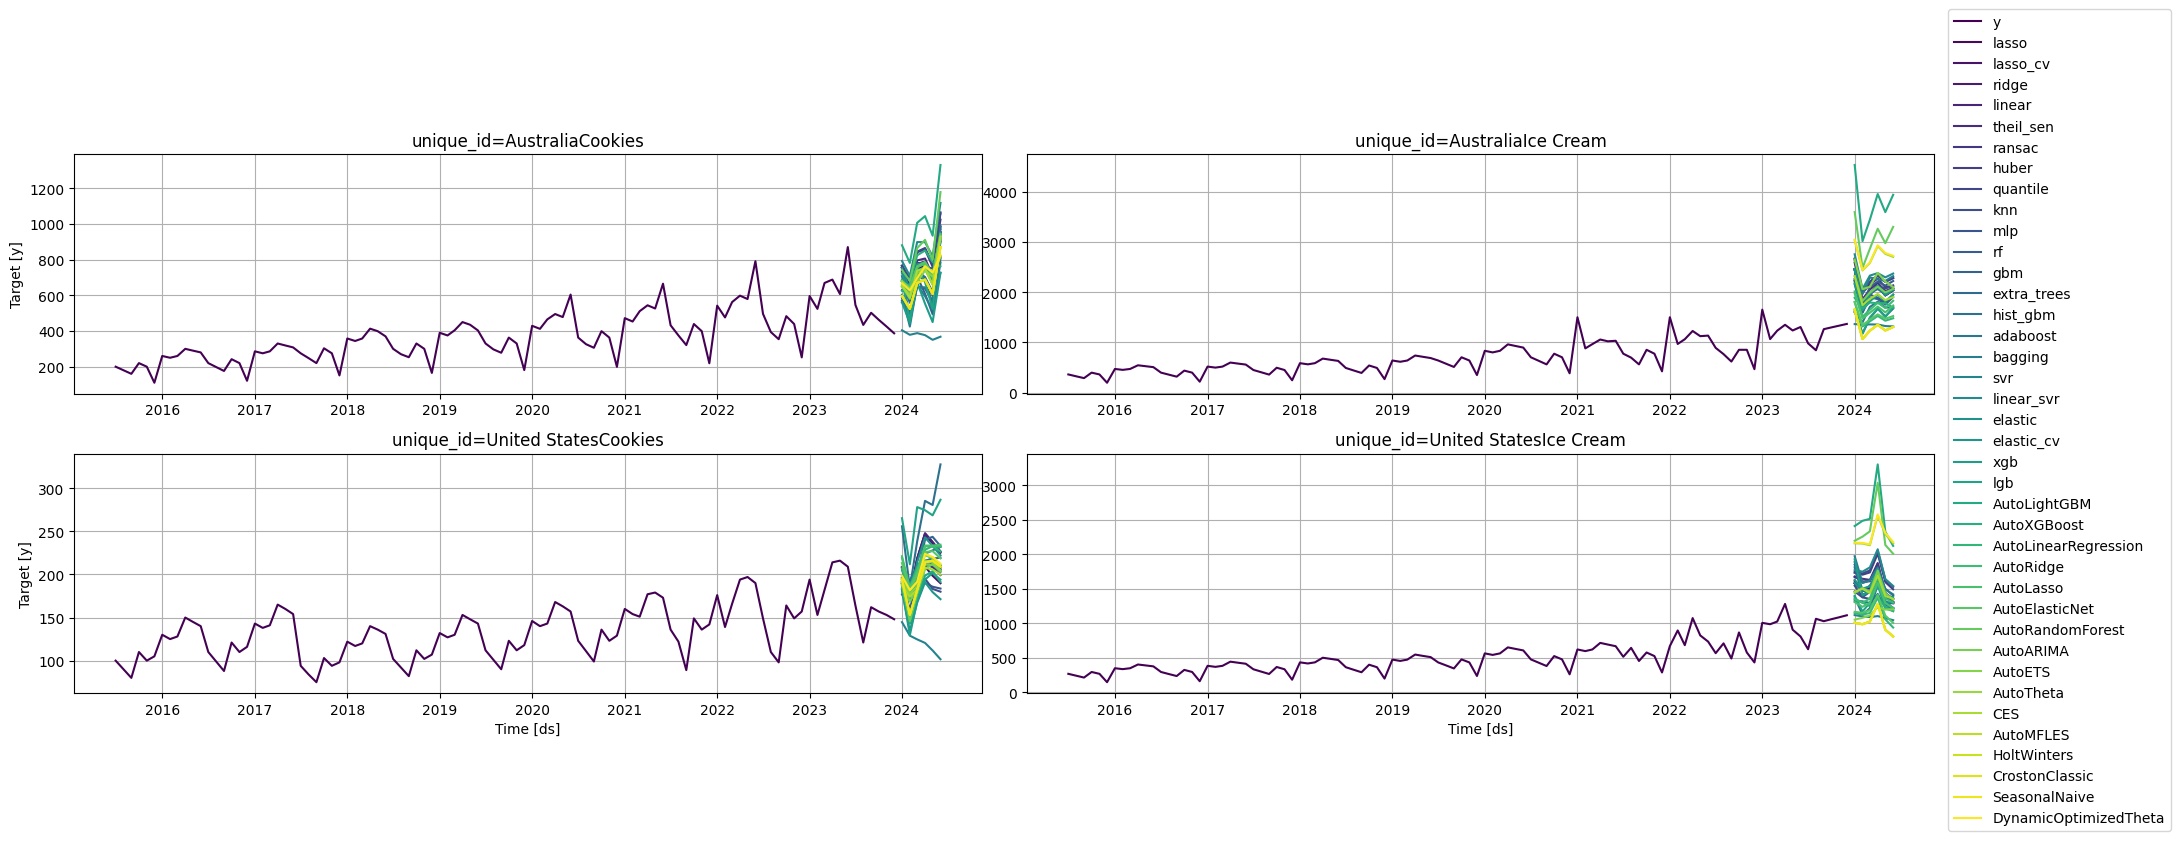

In [40]:
fig = plot_series(df, preds_all)
fig

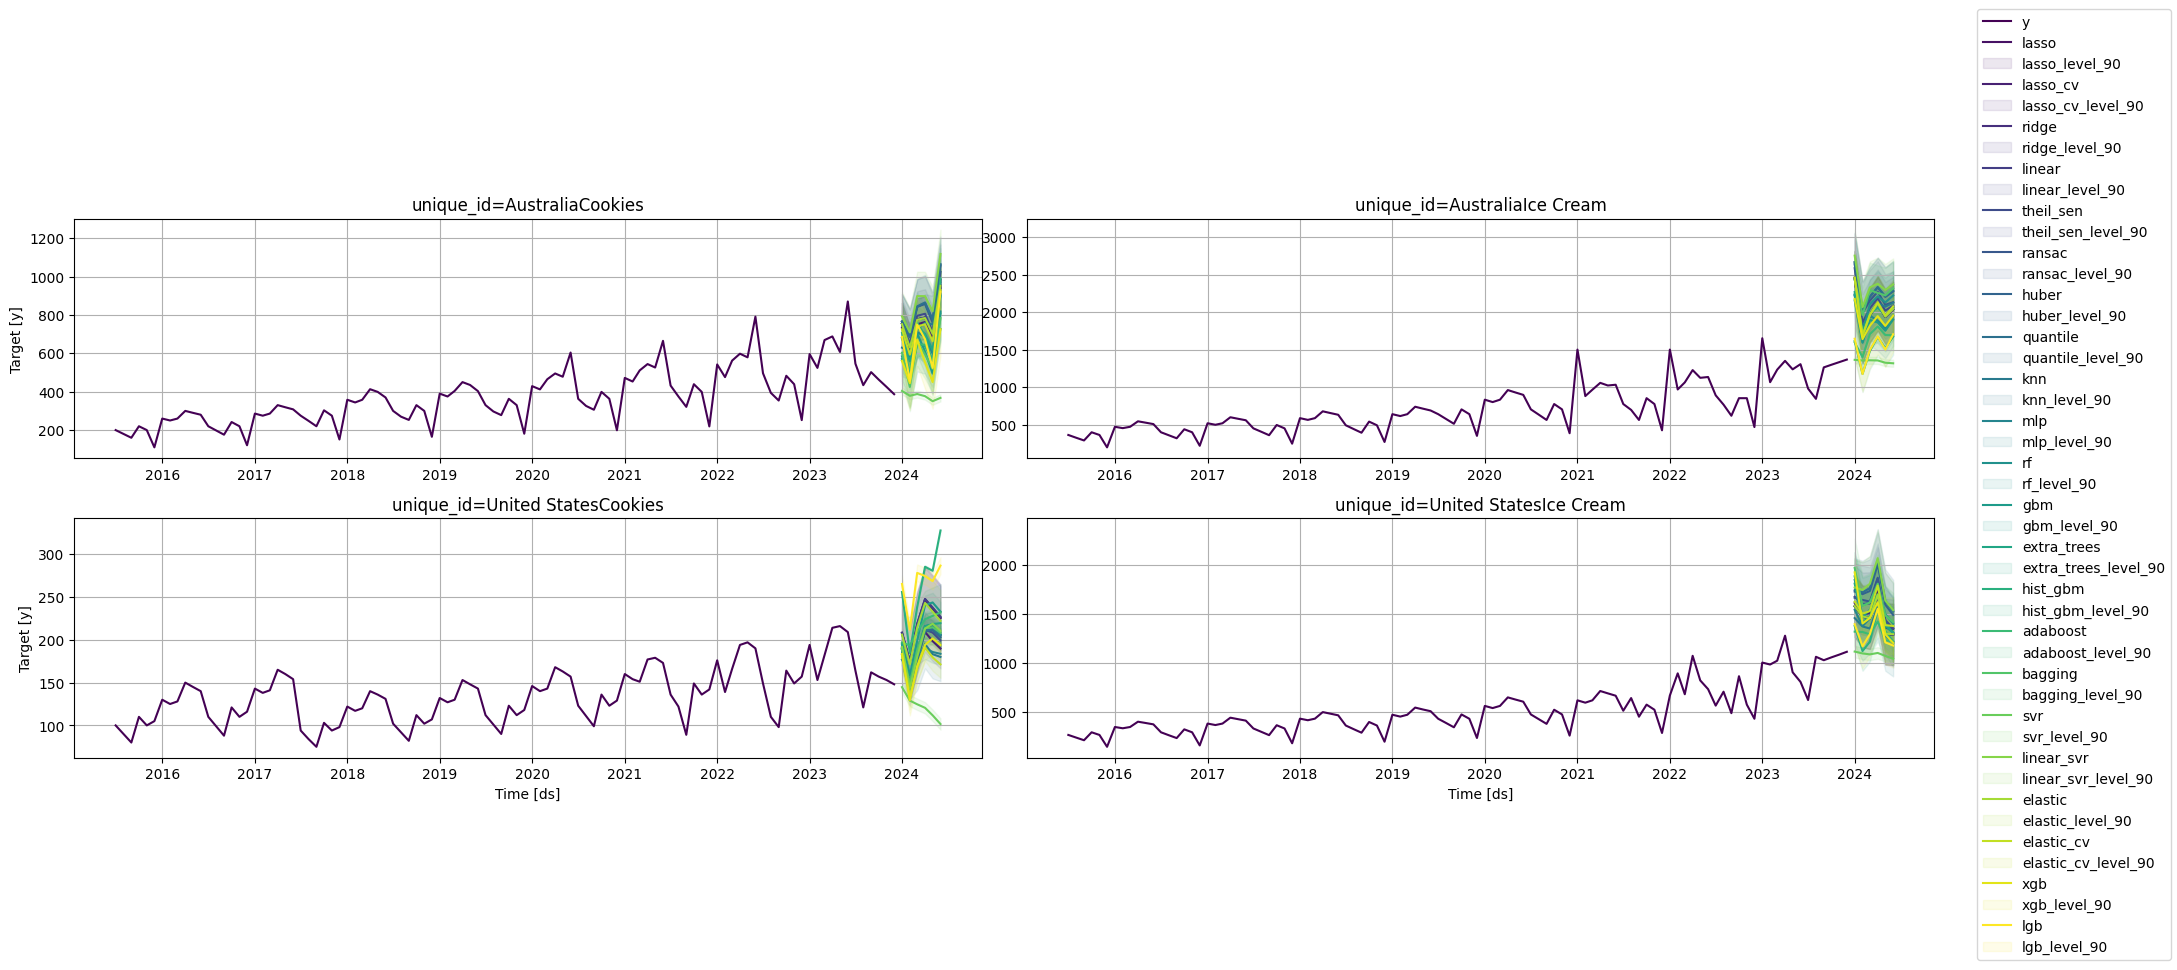

In [41]:
plot_series(df, preds, level = [90])

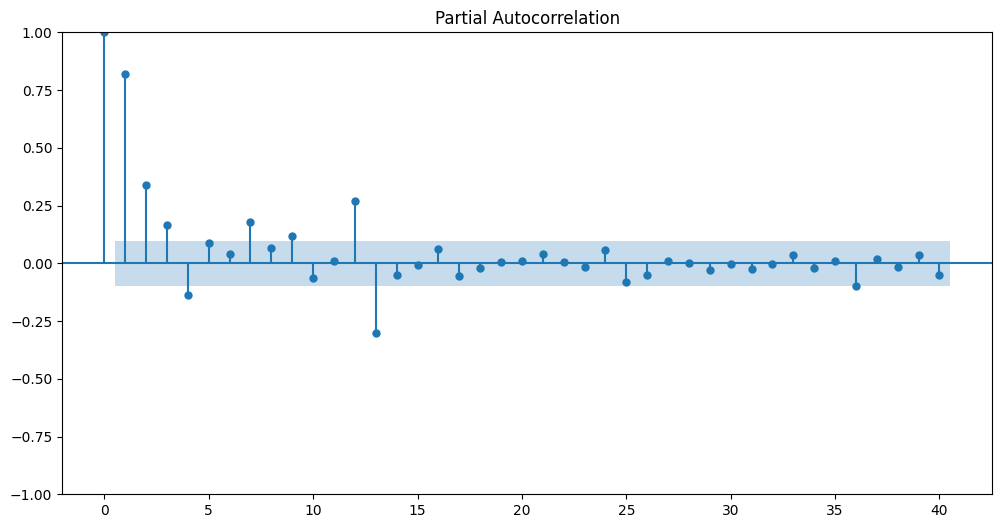

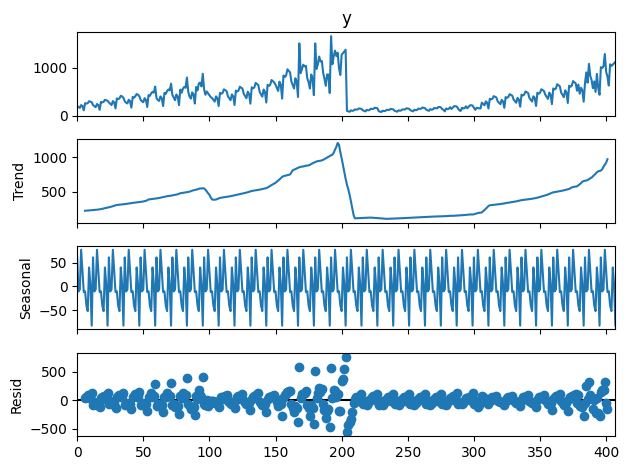

In [42]:
#decompose time series and partial auto correlation
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Partial Autocorrelation
values = df['y']
lags = 40  # You can adjust the number of lags based on your specific needs
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(values, lags=lags, ax=ax)
plt.show()

# Time Series Decomposition
decomposition = seasonal_decompose(values, period = 12, model='additive')  # Choose model='multiplicative' if it fits your series better
fig = decomposition.plot()
plt.show()

In [73]:
print(df)

       unique_id         ds             y
0    Surface Pro 2013-07-01  6.133663e+07
1    Surface Pro 2013-08-01  5.942873e+07
2    Surface Pro 2013-09-01  2.963192e+07
3    Surface Pro 2013-10-01  1.252146e+08
4    Surface Pro 2013-11-01  9.186674e+07
..           ...        ...           ...
126  Surface Pro 2024-01-01  1.370731e+08
127  Surface Pro 2024-02-01  1.118767e+08
128  Surface Pro 2024-03-01  1.407536e+08
129  Surface Pro 2024-04-01  1.450326e+08
130  Surface Pro 2024-05-01  1.163739e+08

[131 rows x 3 columns]


In [43]:
cross_val_fcst_df= fcst.cross_validation(df, h=6, n_windows= 3, level=[90])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 492
[LightGBM] [Info] Number of data points in the train set: 240, number of used features: 8
[LightGBM] [Info] Start training from score 5.900000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [44]:
evaluate_cross_validation(cross_val_fcst_df, smape).min()


NameError: name 'evaluate_cross_validation' is not defined